# Robot Localization
## Chris Tralie

Online and offline bayesian robot localization in a simulated 2D environment

In [4]:
# Install scikit-image if needed
import sys
!{sys.executable} -m pip install scikit-image

In [1]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

## Step 1: Setup Map And Measurements

First, setup the map and a trajectory through it.  Compute perfect measurements from every location on the map, as well as noisy observations from every point on the trajectory

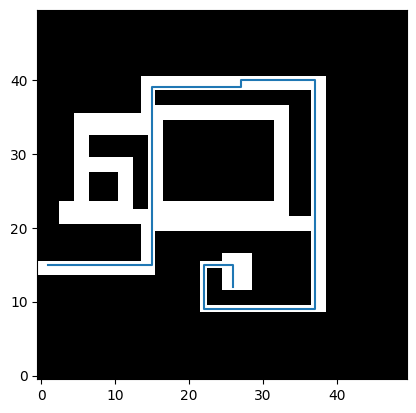

In [2]:
env = Environment("Maze1.png")
res = 50
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])

# Compute perfect scans from each location to use in the observation model
N = len(env.X)
state_scans = [env.get_range_scan(env.X[i], res, alpha=0) for i in range(N)]

# Create observed scans from all locations on the trajectory
alpha = 4
np.random.seed(0)
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]

# Plot the map and the trajectory
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])

## Step 2: Online Tracking with Bayes Filter

MovieWriter ffmpeg unavailable; using Pillow instead.


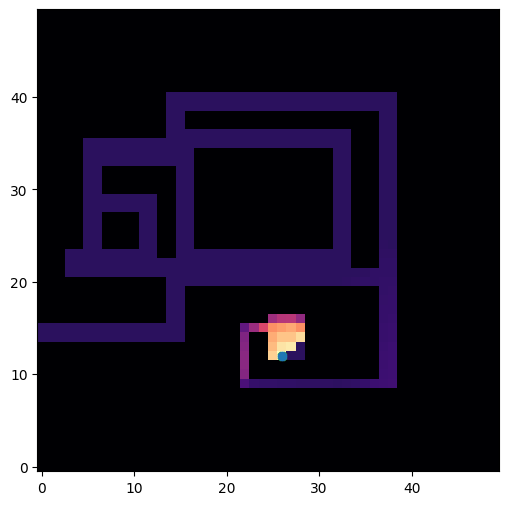

In [3]:
frames = [] # for storing the generated images
fig = plt.figure(figsize=(6, 6))
num_states = env.X.shape[0] # Number of states
belief = np.ones(num_states)/num_states # Initial belief

for i in range(X.shape[0]): # T Filter every measurement that comes in   T = X.shape[0]
    ## TODO: Bayes filtering for this frame index
    probs = np.zeros(num_states)
    for j in range(num_states): # For every possible state
        for k in env.neighbors[j]: # Every state I could have come from to get to j
            # belief at k times probability to transition from k to j
            probs[j] += belief[k]*(1/len(env.neighbors[k]))
        probs[j] = probs[j]*get_measurement_prob(state_scans[j], observed_scans[i], alpha)
    
    belief = probs / np.sum(probs)
    
    plot = env.plot_probabilities(belief, p=1e-2)
    plot.append(plt.scatter([X[i, 0]], [X[i, 1]], c='C0'))
    frames.append(plot)
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
ani.save("BayesFilter.gif")

## Step 3: Offline Tracking with Viterbi

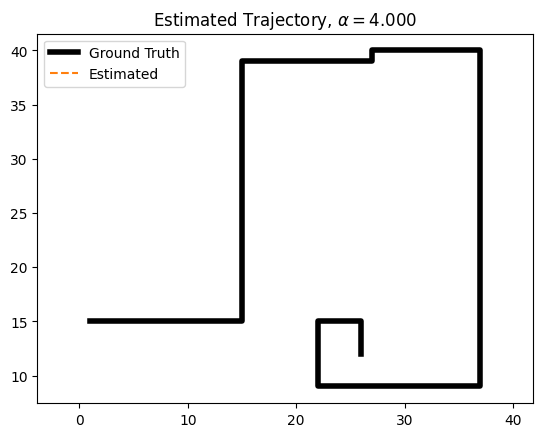

In [7]:
T = len(observed_scans)
K = env.X.shape[0]

L = np.zeros((T, K)) # Maximum accumulated probabilities at every time at every state
B = np.zeros((T, K), dtype=int) # Previous states that led to maximum accumulated probabilities, used for backtracing
B[:, 0] = -1

## Step 1: Initial Conditions
for k in range(K):
    L[0, k] = get_measurement_prob(state_scans[k], observed_scans[0], alpha, use_log=True)
    
## Step 2: Dynamic programming
for n in range(1, T): # For each timestep
    for k, scan in enumerate(state_scans): # For each state on the map
        maxval = -np.inf
        argmax = 0
        ## TODO: Compute the maximum probability and the previous state 
        ## that led to it in maxval and argmax, respectively
        ## Then assign these to L and B
        
        
## Step 3: Maximum selection and backtracing
state = np.argmax(L[-1, :])
states = [state]

## TODO: Finish backtracing


states = np.array(states, dtype=int)
Y = env.X[states, :]


plt.figure()
plt.plot(X[:, 0], X[:, 1], 'k', linewidth=4)
plt.plot(Y[:, 0], Y[:, 1], 'C1', linestyle='--')
plt.legend(["Ground Truth", "Estimated"])
plt.axis("equal")
plt.title("Estimated Trajectory, $\\alpha={:.3f}$".format(alpha))
plt.savefig("Est.svg", facecolor='white')